In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import catboost as cb
print("cb.__version__:", cb.__version__)

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

cb.__version__: 1.2.7


In [2]:
def split_agent_fields(df):
    agent1_cols = ['agent1_selection', 'agent1_exploration_const', 'agent1_playout', 'agent1_score_bounds']
    agent2_cols = ['agent2_selection', 'agent2_exploration_const', 'agent2_playout', 'agent2_score_bounds']
    df[agent1_cols] = df['agent1'].str.split('-', expand=True).iloc[:, 1:]
    df[agent2_cols] = df['agent2'].str.split('-', expand=True).iloc[:, 1:]
    return df


def process_train_data(
    df_train: pd.DataFrame,
    scale: bool = False,
):
    df_train = split_agent_fields(df_train)

    # Identify numerical and categorical columns
    numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

    # Exclude Id, target columns and EnglishRules, LudRules from categoricals
    numerical_cols = [
        col for col in numerical_cols 
        if col not in ['Id', 'num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1', 'utility_agent1']
    ]
    categorical_cols = [
        col for col in categorical_cols 
        if col not in ['GameRulesetName','EnglishRules', 'LudRules']
    ]

    # Remove all NaN/null numerical columns
    all_nan_cols = df_train[numerical_cols].columns[df_train[numerical_cols].isna().all()]
    numerical_cols = [col for col in numerical_cols if col not in all_nan_cols.tolist()]

    # Remove constant columns
    constant_cols = df_train[numerical_cols].std()[df_train[numerical_cols].std() == 0].index.tolist()
    numerical_cols = [col for col in numerical_cols if col not in constant_cols]

    # Apply ordinal encoding to categorical columns
    encoder = OrdinalEncoder()
    df_train[categorical_cols] = encoder.fit_transform(df_train[categorical_cols])
    df_train[categorical_cols] = df_train[categorical_cols].astype(int)

    # Fit and transform the numerical columns of df_train
    if scale:
        scaler = StandardScaler()
        df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])
    else:
        scaler = None

    df_train[numerical_cols] = df_train[numerical_cols].astype(np.float32)
    df_train[categorical_cols] = df_train[categorical_cols].astype(np.int32)

    return df_train, numerical_cols, categorical_cols, encoder, scaler


def process_test_data(
    df_test: pd.DataFrame,
    numerical_cols: list,
    categorical_cols: list,
    encoder: OrdinalEncoder,
    scaler: StandardScaler = None
):
    df_test = split_agent_fields(df_test)

    # Apply ordinal encoding to categorical columns
    df_test[categorical_cols] = encoder.transform(df_test[categorical_cols])

    # Fit and transform the numerical columns of df_test
    if scaler is not None:
        df_test[numerical_cols] = scaler.transform(df_test[numerical_cols])

    df_test[numerical_cols] = df_test[numerical_cols].astype(np.float32)
    df_test[categorical_cols] = df_test[categorical_cols].astype(np.int32)

    return df_test


***
### load and preprocess data

In [3]:
# define some paths
path_raw = Path("/kaggle/input/um-game-playing-strength-of-mcts-variants/")
path_processed = Path("./")
path_results = Path("./")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [4]:
# Call the function
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

Numerical Columns: 588
Categorical Columns: 10


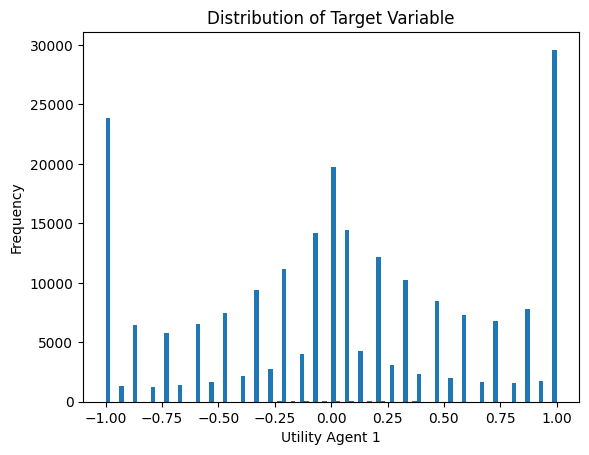

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model

In [6]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        num_folds=5,
        groups_col='GameRulesetName'
    ):
    # Define the number of folds for cross-validation
    gkf = GroupKFold(n_splits=num_folds)
    split_list = gkf.split(df_train, groups=df_train[groups_col])

    # Define the parameters for CatBoost
    params = {
        'objective': "RMSE",
        'learning_rate': 0.05,
        'depth': 5,
        'iterations': 2000,
        'eval_metric': 'RMSE',
        'verbose': 25,
        'random_seed': 42,
    }

    trained_models = []
    oof = pd.DataFrame(index=df_train.index, columns=[f'{target}_true', f'{target}_pred'])
    oof_scores = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols
        )
        val_pool = cb.Pool(
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=25
        )
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)
        y_pred = np.clip(y_pred, -1, 1)
        
        # Compute RMSE on scaled values
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores

# Call the function
# trained_models, oof, oof_scores = train_models(df_train, numerical_cols, categorical_cols)

# save oof predictions
# oof.to_csv(path_results / 'oof_catboost.csv', index=False)

***
### inference

In [7]:
import os
import polars as pl
import kaggle_evaluation.mcts_inference_server

In [8]:
counter = 0

def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    
    global counter
    if counter == 0:
        trained_models,_,_ = train_models(
            df_train, 
            target='utility_agent1', 
            numerical_cols=numerical_cols, 
            categorical_cols=categorical_cols
        )
    counter += 1
    
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [9]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '/kaggle/input/um-game-playing-strength-of-mcts-variants/test.csv',
            '/kaggle/input/um-game-playing-strength-of-mcts-variants/sample_submission.csv'
        )
    )

Fold 1
0:	learn: 0.6153340	test: 0.6157976	best: 0.6157976 (0)	total: 392ms	remaining: 13m 2s
25:	learn: 0.5231252	test: 0.5486679	best: 0.5486679 (25)	total: 8.21s	remaining: 10m 23s
50:	learn: 0.4921313	test: 0.5250547	best: 0.5250547 (50)	total: 15.2s	remaining: 9m 41s
75:	learn: 0.4753529	test: 0.5144691	best: 0.5144691 (75)	total: 22.2s	remaining: 9m 20s
100:	learn: 0.4627020	test: 0.5053563	best: 0.5053563 (100)	total: 29.3s	remaining: 9m 11s
125:	learn: 0.4546458	test: 0.5022563	best: 0.5022563 (125)	total: 37s	remaining: 9m 10s
150:	learn: 0.4462243	test: 0.4983085	best: 0.4983085 (150)	total: 44s	remaining: 8m 59s
175:	learn: 0.4404820	test: 0.4961218	best: 0.4961218 (175)	total: 50.7s	remaining: 8m 45s
200:	learn: 0.4352608	test: 0.4936438	best: 0.4936438 (200)	total: 57.7s	remaining: 8m 36s
225:	learn: 0.4297672	test: 0.4914001	best: 0.4914001 (225)	total: 1m 4s	remaining: 8m 28s
250:	learn: 0.4248268	test: 0.4903135	best: 0.4903135 (250)	total: 1m 12s	remaining: 8m 24s
275:

***